In [266]:
import os
import sys
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from utils import globo, mind
from utils import sparsity

In [268]:
# DATASET, SUFFIX = 'Globo', 'medium'
DATASET, SUFFIX = 'MIND', 'small'

with open("examples/paths.json") as f:
    paths = json.load(f)

PATH_BEHAVIOURS = paths[DATASET]["behaviours"]
PATH_ARTICLES = paths[DATASET]["articles"]

if DATASET == 'Globo':
    articles_df = globo.read_articles(path=PATH_ARTICLES)
    behaviors_presel_df = globo.read_behavior(path=PATH_BEHAVIOURS)
elif DATASET == 'MIND':
    articles_df = mind.read_articles(path=PATH_ARTICLES)
    behaviors_presel_df = mind.read_behavior(path=PATH_BEHAVIOURS)

results_path = f'examples/results/{DATASET}'


Nr of unique articles 68392


In [269]:
articles_df.tail()

,_c0,newsid,title,category,subcategory,cat_subcat,abstract,publication_date,url,cat_as_list
68387,68273,N15890,Watch Jessica Biel Admit She Was NOT a 'Huge' ...,video,popculture,"[video, popculture]",Jessica was hilariously confronted by Jimmy Fa...,2019-10-23,https://assets.msn.com/labs/mind/AAJd7za.html,[video]
68388,68274,N34020,Anxious Democratic donors reportedly seeking a...,video,news,"[video, news]","""A new report in The New York Times details ho...",2019-10-23,https://assets.msn.com/labs/mind/AAJbrCj.html,[video]
68389,68275,N119744,CNN analyst advises Trump to go back to his fa...,video,news,"[video, news]","""CNN legal analyst and former federal prosecut...",2019-10-23,https://assets.msn.com/labs/mind/AAJbcRA.html,[video]
68390,68276,N119588,Salmon shortage threatening food chain in Paci...,video,news,"[video, news]",CNN's Bill Weir reports.,2019-10-23,https://assets.msn.com/labs/mind/AAJbfNt.html,[video]
68391,68278,N33587,How Myles Garrett and Olivier Vernon are shari...,sports,football_nfl,"[sports, football_nfl]","CLEVELAND, Ohio Prior to this season we wond...",2019-10-22,https://assets.msn.com/labs/mind/AAJ7y4f.html,[sports]


In [270]:
behaviors_presel_df.tail()

,index,user,datetime,behavior_array,preselection_array,pool_array
73147,73148,U77536,11/15/2019 8:40:16 PM,"[N28691, N8845, N58434, N37120, N22185, N60033...","[N496-0, N35159-0, N59856-0, N13270-0, N47213-...","[N496, N35159, N59856, N13270, N47213, N26485,..."
73148,73149,U56193,11/15/2019 1:11:26 PM,"[N4705, N58782, N53531, N46492, N26026, N28088...","[N49285-0, N31958-0, N55237-0, N42844-0, N2986...","[N49285, N31958, N55237, N42844, N29862, N1999..."
73149,73150,U16799,11/15/2019 3:37:06 PM,"[N40826, N42078, N15670, N15295, N64536, N4684...","[N7043-0, N512-0, N60215-1, N45057-0, N496-0, ...","[N7043, N512, N60215, N45057, N496, N37055, N1..."
73150,73151,U8786,11/15/2019 8:29:26 AM,"[N3046, N356, N20483, N46107, N44598, N18693, ...","[N23692-0, N19990-0, N20187-0, N5940-0, N13408...","[N23692, N19990, N20187, N5940, N13408, N31958..."
73151,73152,U68182,11/15/2019 11:54:34 AM,"[N20297, N53568, N4690, N60608, N43709, N43123...","[N29862-0, N5472-0, N21679-1, N6400-0, N53572-...","[N29862, N5472, N21679, N6400, N53572, N50775,..."


## Sparsity Analysis

In [271]:
users_interactions_count_df = (
    behaviors_presel_df[['user', 'behavior_array']]
    .explode('behavior_array')
    .rename({'behavior_array': 'newsid'}, axis=1)
    .groupby('user')
    .count()
)

users_interactions_count_df.tail()

,newsid
user,
U9990,1
U9994,1
U9996,20
U9998,28
U9999,42


In [272]:
items_interactions_count_df = (
    behaviors_presel_df[['user', 'behavior_array']]
    .explode('behavior_array')
    .rename({'behavior_array': 'newsid'}, axis=1)
    .groupby('newsid')
    .count()
)

items_interactions_count_df = pd.merge(
    articles_df[['newsid']],
    items_interactions_count_df,
    on='newsid',
    how='left'
).fillna(0)

items_interactions_count_df.tail()

,newsid,user
68387,N15890,0.0
68388,N34020,0.0
68389,N119744,0.0
68390,N119588,0.0
68391,N33587,0.0


In [273]:
n_users = behaviors_presel_df['user'].nunique()
n_items = articles_df['newsid'].nunique()
n_interactions = behaviors_presel_df['behavior_array'].explode().nunique()
user_gini = sparsity.gini_coefficient(users_interactions_count_df['newsid'].values)
item_gini = sparsity.gini_coefficient(items_interactions_count_df['user'].values)

100%|██████████| 68391/68391 [00:03<00:00, 20450.21it/s]


In [274]:
print ('Number of users:', n_users)
print ('Number of items:', n_items)
print ('Number of interactions:', n_interactions)
print ('Space Log:', sparsity.space_log(n_users, n_items))
print ('Shape Log:', sparsity.shape_log(n_users, n_items))
print ('Density Log:', sparsity.density_log(n_users, n_items, n_interactions))
print ('Overall Sparsity:', 1-10**(sparsity.density_log(n_users, n_items, n_interactions)))
print ('User Gini:', user_gini)
print ('Item Gini:', item_gini)

Number of users: 50000
Number of items: 68392
Number of interactions: 37682
Space Log: 6.533975308409208
Shape Log: -0.1360352997371709
Density Log: -4.957841363176031
Overall Sparsity: 0.9999889805825243
User Gini: 0.6765973475342618
Item Gini: 0.9596907126510239


## Category Distribution

In [275]:
df_plot = (
    articles_df[['newsid', 'cat_as_list']]
    .explode('cat_as_list')
    .rename({'cat_as_list': 'cat'}, axis=1)
    .groupby('cat')
    .count()
    .sort_values(by='newsid', ascending=False)
    .reset_index()
)
df_plot.head()

,cat,newsid
0,news,21036
1,sports,19972
2,finance,4247
3,foodanddrink,3386
4,lifestyle,3249


100%|██████████| 16/16 [00:00<00:00, 15505.74it/s]


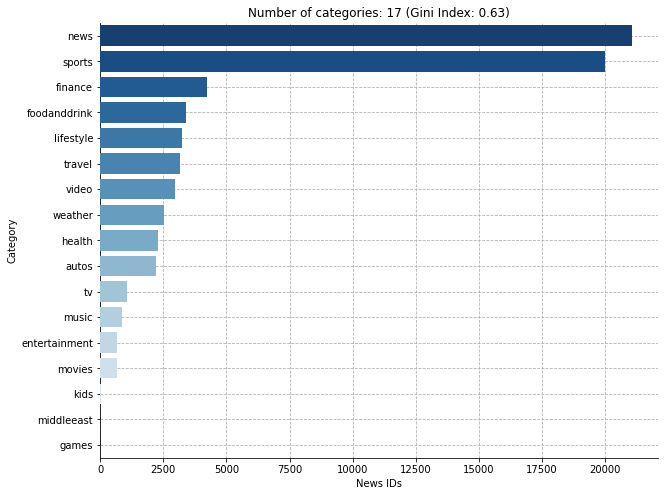

In [277]:
def plot_cat_distribution(df:pd.DataFrame, figsize=(10,8)):
    n_categories = df["cat"].nunique()
    gini_index = '{:.02f}'.format(sparsity.gini_coefficient(df_plot['newsid'].values))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    sns.barplot(
        data=df,
        x='newsid',
        y='cat',
        ax=ax,
        palette='Blues_r',
        zorder=3
    )
    ax.grid(True, linestyle='--', zorder=1)
    ax.set_ylabel('Category'), ax.set_xlabel('News IDs')
    ax.set_title(f'Number of categories: {n_categories} (Gini Index: {gini_index})')
    [ax.spines[spine].set_visible(False) for spine in ["top", "right"]]
    return fig, ax

fig, ax = plot_cat_distribution(df_plot)
fig.savefig(os.path.join(results_path, 'plots', f'articles_category_distribution.png'), bbox_inches='tight')

In [282]:
articles_df.assign(size_cat_list = articles_df['cat_subcat'].apply(len))[['size_cat_list', 'newsid']].groupby('size_cat_list').count()

,newsid
size_cat_list,
2,68392


## Anonymous vs. Logged

In [278]:
if 'userType' in behaviors_presel_df.columns:
    behaviors_presel_df[['userType', 'user']].drop_duplicates().groupby(['userType']).count()

# RADio Metrics

## Loading Calibration, Representation and Fragmentation files

Calibration, representation and fragmentation are computed for each algorithm using the `run_radio_metric.py` script. To run it, use the following command:

```bash
python examples/run_radio_metric.py --dataset={dataset} --algo={algorithm}
```

Available algorithms:
- Globo
    - als
    - recents
    - top24h

Definitions from the [original article](https://arxiv.org/pdf/2209.13520.pdf):

- **Calibration**: _measures to what extent the recommendations are tailored to a user's preferences_.
- **Representation** _aims to approximate a notion of viepoint diversity (e.g. mentions of political topics or political parties where the viewpoints are expressed categorically_).
- **Fragmentation**: _reflects to what extent we can speak of a common public sphere, or whether the users exist in their own bubble_.

In [258]:
algos = ['als', 'recents', 'top24h']
top_ats = [3, 4, 5, 6, 7, 8, 9, 10, 11]
metric_names = ["calibration", "representation", "fragmentation"]
figsize=(10,8)

df_metrics = pd.DataFrame()

for algo in algos:
    for top_at in top_ats:
        for metric_name in metric_names:
            df_temp = pd.read_parquet(f'{results_path}/{algo}_at_{top_at}_{metric_name}.parquet')
            df_temp['algo'] = algo
            df_temp['top_at'] = top_at
            df_temp['metric_name'] = metric_name
            df_temp.rename({metric_name: "metric_value"}, axis=1, inplace=True)
            df_temp.rename({metric_name+"_bin": "metric_value_bin"}, axis=1, inplace=True)
            df_metrics = pd.concat([df_metrics, df_temp])

df_metrics["provider"] = df_metrics["user"].apply(lambda x: "cadun" if '-' in x else "anonymous")

df_metrics.tail()

,index,user,metric_value,algo,metric_value_bin,top_at,metric_name,provider
1649,feb259de-f64e-44c1-b3e1-e7ab5d25fc0c,9756103b-ab28-4533-b240-61a671624e6d,0.571858,top24h,0.570,11,fragmentation,cadun
1650,feb4988b-7b6f-4d36-beed-586df5b19b5e,f9df7469-f2ca-49e7-b794-2de538fee5b7,0.762063,top24h,0.760,11,fragmentation,cadun
1651,fed80559-9d79-4689-b4df-dd6c83842046,12374968894806540356,0.475294,top24h,0.475,11,fragmentation,anonymous
1652,ffd5b2e7-ebe6-447f-8502-e39c8a794ad7,17903464343051858353,0.526334,top24h,0.525,11,fragmentation,anonymous
1653,ffdbdffa-b3e2-48f5-860c-11f4a66363ef,3553417659088873286,0.651403,top24h,0.650,11,fragmentation,anonymous


### Violin Plot

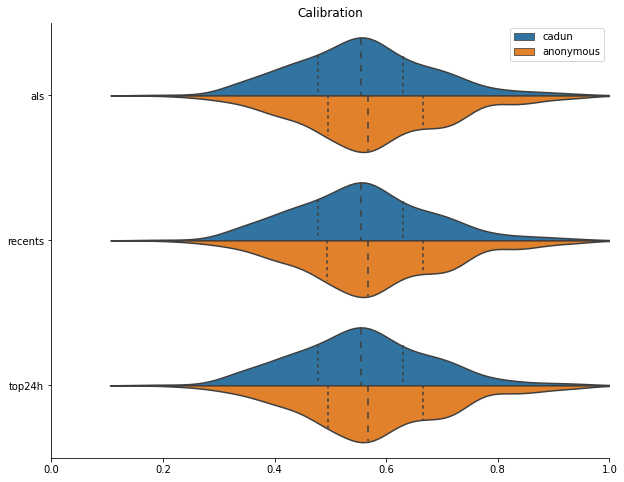

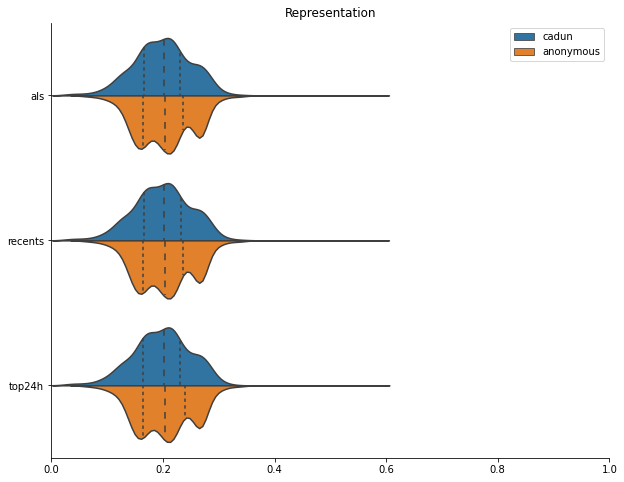

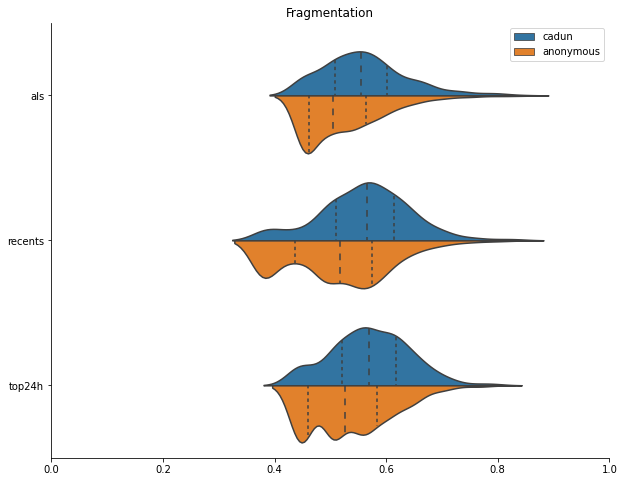

In [261]:
def plot_violin_metric(df:pd.DataFrame, title:str, figsize=(16,10)):

    fig, ax = plt.subplots(nrows=1, figsize=figsize, sharex=True)
    sns.violinplot(
        ax=ax,
        data=df_plot,
        y="algo",
        x="metric_value",
        stat="probability",
        bins=200,
        inner="quartile",
        split=True,
        hue="provider",
        zorder=1
    )
    ax.legend()
    # ax.grid(True, linestyle='--', zorder=5)
    ax.set_xlim([0,1])
    [ax.spines[spine].set_visible(False) for spine in ["top", "right"]]
    ax.set_xlabel(''), ax.set_ylabel('')
    ax.set_title(title)

    return fig, ax

top_at = 10
for metric_name in metric_names:
    df_plot = df_metrics.query("top_at == @top_at and metric_name == @metric_name")
    fig, ax = plot_violin_metric(df_plot, metric_name.title(), figsize=figsize)
    fig.savefig(os.path.join(results_path, 'plots', f'{metric_name}_at_{top_at}.png'), bbox_inches='tight')


### Rank Cutoff

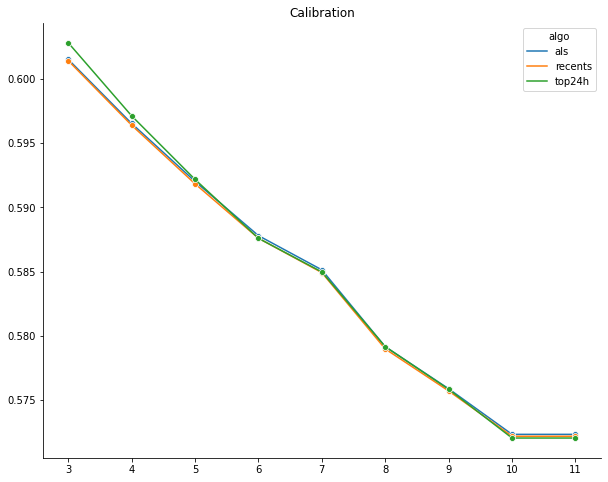

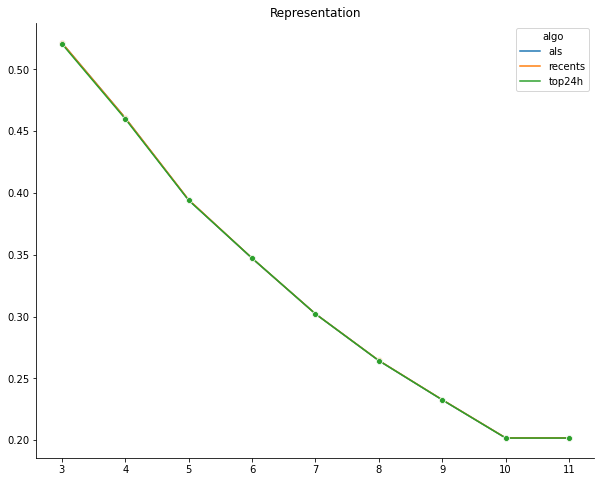

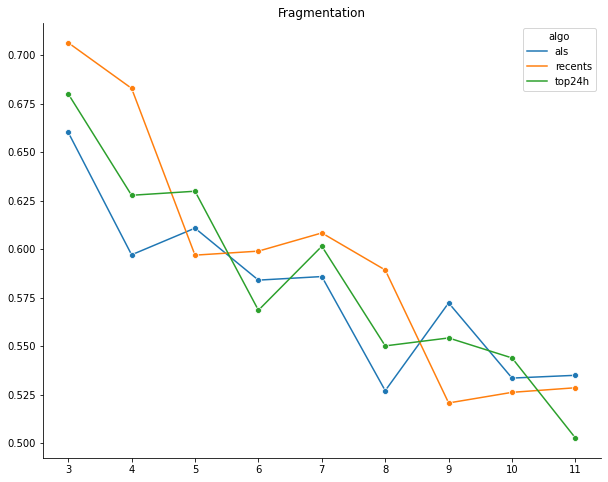

In [264]:
def plot_rank_cuoff(df:pd.DataFrame, title:str, figsize=(16,10)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.lineplot(
        ax=ax,
        data=df_plot,
        x='top_at',
        y='metric_value',
        hue='algo',
        markers=True,
        marker='o'
    )
    [ax.spines[spine].set_visible(False) for spine in ["top", "right"]]
    ax.set_xlabel(''), ax.set_ylabel('')
    ax.set_title(metric_name)
    ax.set_xticks(df_plot['top_at'].unique())
    ax.set_title(title)

    return fig, ax


for metric_name in metric_names:
    df_plot = df_metrics.query("metric_name == @metric_name")[['metric_value', 'top_at', 'algo']]
    df_plot = df_plot.groupby(['algo', 'top_at'])['metric_value'].mean().reset_index()
    fig, ax = plot_rank_cuoff(df_plot, title=metric_name.title(), figsize=figsize)
    fig.savefig(os.path.join(results_path, 'plots', f'{metric_name}_rank_cutoff.png'), bbox_inches='tight')
